In [1]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import datetime
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')
from torchvision.datasets.utils import check_integrity, download_and_extract_archive, download_url, verify_str_arg
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
# Prerequirements: have kaggle.json in ~/.kaggle
# Instructions: Generate json and put it in ~/.kaggle from: https://www.kaggle.com/settings/account
import opendatasets as od
from pandas import DataFrame
import seaborn as sns

/home/catalin/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# torch.multiprocessing.set_start_method('spawn')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Add this line if you don't want to use GPU
# device = torch.device('cpu') 
torch.set_default_device(device)

- Identificarea setului de date
- Colectarea setului de date

In [3]:
dataset_folder = './fruits-fresh-and-rotten-for-classification'
if os.path.exists(dataset_folder):
    print('Dataset already exists')
else:
    od.download("https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification/download?datasetVersionNumber=1")

Dataset already exists


In [4]:
class FruitsDataset(Dataset):
    def __init__(self,path,subset='train',transforms=None):
        self.subset = subset
        if self.subset == 'train':
            self.PATH = os.path.join(path,'train','*','*.png')
        elif self.subset == 'test':
            self.PATH = os.path.join(path,'test','*','*.png')
        self.images_paths = glob.glob(self.PATH)
        self.labels = [] 
        fresh_classes,fruits_classes = ['fresh','rotten'],['apple','banana','range']
        for fruit in self.images_paths:
            rotten_class,fruit_class = 0,0
            if fresh_classes[1] in fruit.split('/')[-2]:
                rotten_class = 1
            if fruits_classes[1] in fruit:
                fruit_class = 1
            elif fruits_classes[2] in fruit:
                fruit_class = 2
            self.labels.append((fruit_class,rotten_class))
        self.transforms = transforms

    def __getitem__(self,index):
        image_path = self.images_paths[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        labels = self.labels[index]
        if self.transforms is not None:
            return self.transforms(image),labels
        return image,labels

    def __len__(self):
        return(len(self.images_paths))

In [5]:
class RamDataset(torch.utils.data.Dataset):
    def __init__(self, dataset: Dataset):
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
        self.images, self.labels = next(iter(data_loader))
    def __getitem__(self, index):
        return self.images[index], self.labels[0][index], self.labels[1][index]
    def __len__(self):
        return self.images.shape[0]

Preprocesarea setului de date:
- Redimensionarea imaginilor la 32*32
- Normalizarea valorilor pixelilor

In [6]:
transformations = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.7321, 0.6322, 0.5291),(0.3302, 0.3432, 0.3701)),
                                      transforms.Resize((32,32))])
dataset = RamDataset(FruitsDataset(dataset_folder,transforms = transformations))


- Intelegerea setului de date

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of images in the dataset: 10901
Resolution of the images after redimensioning: torch.Size([32, 32])
Number of channels in the images: 3. 3 channels are for RGB imgages, 1 channel is for grayscale images.
Fruit class: 0, Fresh class: 0
Rotten classes are: ['fresh','rotten']
Fruits classes are: ['apple','banana','orange']
Unique fresh classes: [0 1 2]
Unique rotten classes: [0 1 2]
Number of images: Apple: 4035, Banana: 3805, Orange: 3061
Number of images: Fresh: 4740, Rotten: 6161
Number of images: Fresh Apple: 1693, Rotten Apple: 2342
Number of images: Fresh Banana: 1581, Rotten Banana: 2224
Number of images: Fresh Orange: 1466, Rotten Orange: 1595


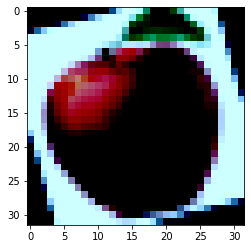

In [7]:
print(f"Number of images in the dataset: {len(dataset)}")
print(f"Resolution of the images after redimensioning: {dataset[0][0].shape[1:]}")
print(f"Number of channels in the images: {dataset[0][0].shape[0]}. 3 channels are for RGB imgages, 1 channel is for grayscale images.")
image, fruit_class, fresh_class = dataset[0]
image = image.permute(1,2,0) # Changing the shape from (3, 32, 32) to (32, 32, 3)
plt.imshow(image)
print(f"Fruit class: {fruit_class.cpu()}, Fresh class: {fresh_class.cpu()}")
print(f"Rotten classes are: ['fresh','rotten']")
print(f"Fruits classes are: ['apple','banana','orange']")
cpu_labels = [el.cpu() for el in dataset.labels]
# Unique labels
unique_fresh_classes,unique_rotten_classes = np.unique(cpu_labels[0],axis=0),np.unique(cpu_labels[0],axis=0)
print(f"Unique fresh classes: {unique_fresh_classes}")
print(f"Unique rotten classes: {unique_rotten_classes}")
number_of_apple_images, number_of_banana_images, number_of_orange_images = np.count_nonzero(cpu_labels[0]==0), np.count_nonzero(cpu_labels[0]==1), np.count_nonzero(cpu_labels[0]==2)
print(f"Number of images: Apple: {number_of_apple_images}, Banana: {number_of_banana_images}, Orange: {number_of_orange_images}")
number_of_fresh_images, number_of_rotten_images = np.count_nonzero(cpu_labels[1]==0), np.count_nonzero(cpu_labels[1]==1)
print(f"Number of images: Fresh: {number_of_fresh_images}, Rotten: {number_of_rotten_images}")
# Combined classes
number_of_fresh_apple_images = np.count_nonzero((cpu_labels[0]==0) & (cpu_labels[1]==0))
number_of_rotten_apple_images = np.count_nonzero((cpu_labels[0]==0) & (cpu_labels[1]==1))
number_of_fresh_banana_images = np.count_nonzero((cpu_labels[0]==1) & (cpu_labels[1]==0))
number_of_rotten_banana_images = np.count_nonzero((cpu_labels[0]==1) & (cpu_labels[1]==1))
number_of_fresh_orange_images = np.count_nonzero((cpu_labels[0]==2) & (cpu_labels[1]==0))
number_of_rotten_orange_images = np.count_nonzero((cpu_labels[0]==2) & (cpu_labels[1]==1))
print(f"Number of images: Fresh Apple: {number_of_fresh_apple_images}, Rotten Apple: {number_of_rotten_apple_images}")
print(f"Number of images: Fresh Banana: {number_of_fresh_banana_images}, Rotten Banana: {number_of_rotten_banana_images}")
print(f"Number of images: Fresh Orange: {number_of_fresh_orange_images}, Rotten Orange: {number_of_rotten_orange_images}")

<Axes: >

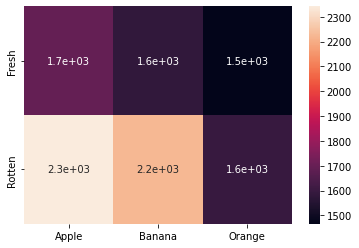

In [141]:
data = {'Apple': [number_of_fresh_apple_images,number_of_rotten_apple_images],
        'Banana': [number_of_fresh_banana_images,number_of_rotten_banana_images],
        'Orange': [number_of_fresh_orange_images,number_of_rotten_orange_images]}
df = DataFrame(data,columns=['Apple','Banana','Orange'],index=['Fresh','Rotten'])
sns.heatmap(df, annot=True)

In [194]:
batch_size = 100
validation_split = 0.2
learning_rate = 1e-2
number_of_epochs = 50

In [195]:
shuffle_dataset,random_seed = True,42
dataset_size = len(dataset)
indices,split = list(range(dataset_size)),int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=SubsetRandomSampler(val_indices))

In [196]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.common_convolution_1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
        self.common_convolution_2 = nn.Conv2d(16,8,kernel_size=3,padding=1)
        self.common_fully_connected_1 = nn.Linear(8*8*8,32)
        self.fc_fresh = nn.Linear(32,2)
        self.fc_fruit = nn.Linear(32,3)
    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.common_convolution_1(x)),2)
        out = F.max_pool2d(torch.tanh(self.common_convolution_2(out)),2)
        out = out.view(-1,8*8*8)
        out = self.common_fully_connected_1(out)
        return self.fc_fresh(out),self.fc_fruit(out)

In [197]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
loss_function = nn.CrossEntropyLoss()

In [198]:
def training_loop(number_of_epochs, optimizer, scheduler, model, loss_function, train_loader, validation_loader):
    train_size, validation_size = len(train_indices),len(val_indices)
    fresh_loss_history, fruits_loss_history = [], []
    fresh_accuracy_history, fruits_accuracy_history = [], []
    validation_fruits_loss_history, validation_fresh_loss_history = [], []
    validation_fruits_accuracy_history, validation_fresh_accuracy_history = [], []
    progress_bar = tqdm(range(number_of_epochs))
    for _ in progress_bar:
        loss_value_fresh, loss_value_fruits = 0.0, 0.0
        accuracy_fresh, accuracy_fruits = 0.0, 0.0
        for imgs, fruit_class, fresh_class in train_loader:
            imgs, fruit_class, fresh_class = imgs.to(device=device), fruit_class.to(device=device), fresh_class.to(device=device)
            output_fresh, output_fruits = model(imgs)
            fresh_class = F.one_hot(fresh_class, 2).float()
            fruit_class = F.one_hot(fruit_class, 3).float()

            loss_fresh = loss_function(output_fresh, fresh_class)
            loss_fruit = loss_function(output_fruits, fruit_class)
            optimizer.zero_grad()
            (loss_fresh + loss_fruit).backward()
            optimizer.step()

            loss_value_fruits += loss_fruit.item()
            loss_value_fresh += loss_fresh.item()

            _, predicted_fresh = torch.max(output_fresh, 1)
            _, predicted_fruits = torch.max(output_fruits, 1)
            accuracy_fresh += (predicted_fresh == torch.argmax(fresh_class, 1)).sum()
            accuracy_fruits += (predicted_fruits == torch.argmax(fruit_class, 1)).sum()

        scheduler.step()
        with torch.no_grad():
            validation_value_fresh, validation_value_fruits = 0.0, 0.0
            validation_accuracy_fresh, validation_accuracy_fruits = 0.0, 0.0
            for imgs, fruit_class, fresh_class in validation_loader:
                imgs, fruit_class, fresh_class = imgs.to(device=device), fruit_class.to(device=device), fresh_class.to(device=device)
                output_fresh, output_fruits = model(imgs)
                fresh_class = F.one_hot(fresh_class, 2).float()
                fruit_class = F.one_hot(fruit_class, 3).float()

                loss_fresh = loss_function(output_fresh, fresh_class)
                loss_fruit = loss_function(output_fruits, fruit_class)
                
                validation_value_fresh += loss_fresh.item()
                validation_value_fruits += loss_fruit.item()

                _, predicted_fresh = torch.max(output_fresh, 1)
                _, predicted_fruits = torch.max(output_fruits, 1)
                validation_accuracy_fresh += (predicted_fresh == torch.argmax(fresh_class, 1)).sum()
                validation_accuracy_fruits += (predicted_fruits == torch.argmax(fruit_class, 1)).sum()
        # Calculate additional metrics here
        fresh_accuracy = accuracy_fresh.item() / train_size
        fruits_accuracy = accuracy_fruits.item() / train_size
        validation_fresh_accuracy = validation_accuracy_fresh.item() / validation_size
        validation_fruits_accuracy = validation_accuracy_fruits.item() / validation_size
        # Add metrics to history
        fresh_loss_history.append(loss_value_fresh / train_size)
        fruits_loss_history.append(loss_value_fruits / train_size)
        fresh_accuracy_history.append(fresh_accuracy)
        fruits_accuracy_history.append(fruits_accuracy)
        validation_fresh_loss_history.append(validation_value_fresh / validation_size)
        validation_fruits_loss_history.append(validation_value_fruits / validation_size)
        validation_fresh_accuracy_history.append(validation_fresh_accuracy)
        validation_fruits_accuracy_history.append(validation_fruits_accuracy)

        progress_bar.set_description(f"Loss fresh: {'%.3f' % (fresh_loss_history[-1])} vs {'%.3f' % (validation_fresh_loss_history[-1])} | Loss fruits: {'%.3f' % (fruits_loss_history[-1])} vs {'%.3f' % (validation_fruits_loss_history[-1])} | Accuracy fresh: {'%.3f' % fresh_accuracy_history[-1]} vs {'%.3f' % validation_fresh_accuracy_history[-1]} | Accuracy fruits: {'%.3f' % fruits_accuracy_history[-1]} vs {'%.3f' % validation_fruits_accuracy_history[-1]}")

    return fresh_loss_history, fruits_loss_history, fresh_accuracy_history, fruits_accuracy_history, validation_fresh_loss_history, validation_fruits_loss_history, validation_fresh_accuracy_history, validation_fruits_accuracy_history

train_size, validation_size = len(train_indices),len(val_indices)
fresh_loss_history, fruits_loss_history, fresh_accuracy_history, fruits_accuracy_history, validation_fresh_loss_history, validation_fruits_loss_history, validation_fresh_accuracy_history, validation_fruits_accuracy_history = training_loop(number_of_epochs=number_of_epochs,optimizer=optimizer, scheduler=scheduler, model = model,loss_function = loss_function,train_loader = train_loader, validation_loader=validation_loader)

  0%|          | 0/50 [00:00<?, ?it/s]

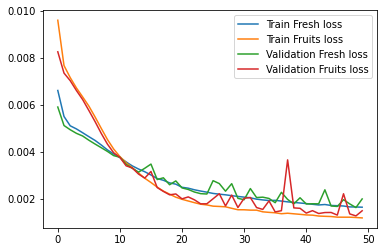

In [202]:
# Print the loss
plt.plot(fresh_loss_history,label='Train Fresh loss')
plt.plot(fruits_loss_history,label='Train Fruits loss')
plt.plot(validation_fresh_loss_history,label='Validation Fresh loss')
plt.plot(validation_fruits_loss_history,label='Validation Fruits loss')
plt.legend()
plt.show()

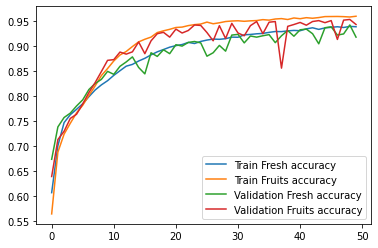

In [203]:
# Print the accuracy
plt.plot(fresh_accuracy_history,label='Train Fresh accuracy')
plt.plot(fruits_accuracy_history,label='Train Fruits accuracy')
plt.plot(validation_fresh_accuracy_history,label='Validation Fresh accuracy')
plt.plot(validation_fruits_accuracy_history,label='Validation Fruits accuracy')
plt.legend()
plt.show()

In [201]:
# Save the model
torch.save(model.state_dict(), 'Detector.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

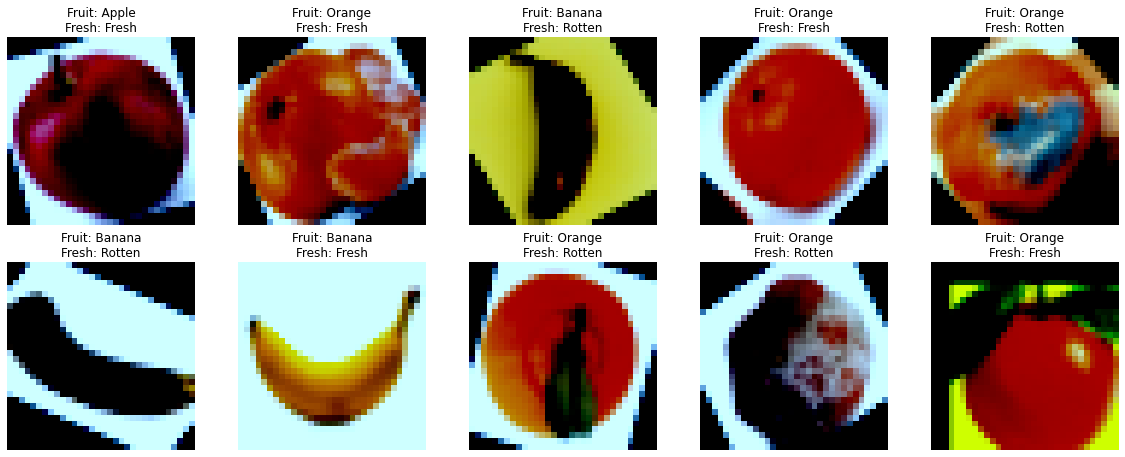

In [230]:
fresh_dictionary = {0: 'Fresh', 1: 'Rotten'}
fruits_dictionary = {0: 'Apple', 1: 'Banana', 2: 'Orange'}
# Get model from file
model = Net().to(device=device)
model.load_state_dict(torch.load('Detector.pt'))
with torch.no_grad():
    for imgs, fruit_class, fresh_class in validation_loader:
        imgs, fruit_class, fresh_class = imgs.to(device=device), fruit_class.to(device=device), fresh_class.to(device=device)
        output_fresh, output_fruits = model(imgs)
        output_fresh = F.softmax(output_fresh, dim=1)
        output_fruits = F.softmax(output_fruits, dim=1)
        # Plot the results
        fig = plt.figure(figsize=(20,20))
        for i in range(10):
            img = imgs[i].cpu().permute(1, 2, 0)
            ax = fig.add_subplot(5, 5, i + 1)
            ax.axis('off')
            ax.set_title(f'Fruit: {fruits_dictionary[torch.argmax(output_fruits[i]).item()]}\nFresh: {fresh_dictionary[torch.argmax(output_fresh[i]).item()]}')
            ax.imshow(img)
        break

Fresh accuracy: 93.00%
Fruits accuracy: 97.00%
Fresh precision: [0.85714286 1.        ]
Fruits precision: [1.  1.  0.9]
Fresh recall: [1.         0.87931034]
Fruits recall: [0.97368421 0.94285714 1.        ]
Fresh F1: [0.92307692 0.93577982]
Fruits F1: [0.98666667 0.97058824 0.94736842]


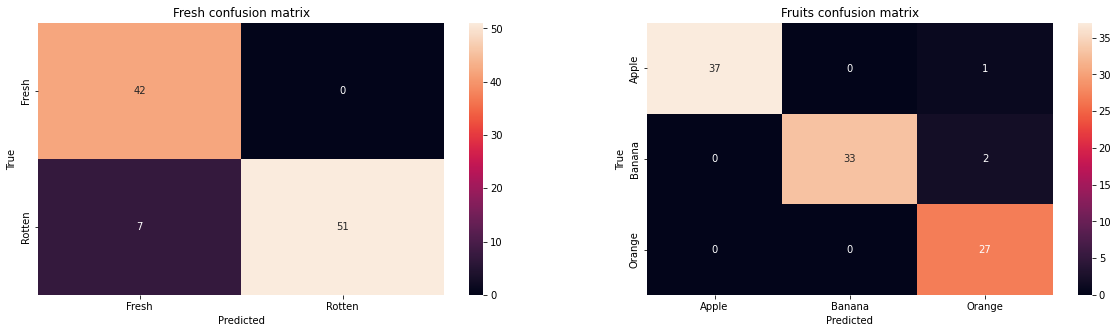

In [247]:
# Heatmap
from sklearn.metrics import confusion_matrix


with torch.no_grad():
    for imgs, fruit_class, fresh_class in validation_loader:
        imgs, fruit_class, fresh_class = imgs.to(device=device), fruit_class.to(device=device), fresh_class.to(device=device)
        output_fresh, output_fruits = model(imgs)
        output_fresh = F.softmax(output_fresh, dim=1)
        output_fruits = F.softmax(output_fruits, dim=1)
        # Plot the results
        confusion_fresh = confusion_matrix(fresh_class.cpu(), torch.argmax(output_fresh, 1).cpu())
        confusion_fruits = confusion_matrix(fruit_class.cpu(), torch.argmax(output_fruits, 1).cpu())
        fig = plt.figure(figsize=(20,5))
        ax = fig.add_subplot(1, 2, 1)
        fresh_labels = ['Fresh', 'Rotten']
        fruits_dictionary = ['Apple', 'Banana', 'Orange']
        # Set the labels
        sns.heatmap(confusion_fresh, annot=True, ax=ax, fmt='d')
        ax.set_xticklabels(fresh_labels)
        ax.set_yticklabels(fresh_labels)
        ax.set_title('Fresh confusion matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

        ax = fig.add_subplot(1, 2, 2)
        sns.heatmap(confusion_fruits, annot=True, ax=ax, fmt='d')
        ax.set_xticklabels(fruits_dictionary)
        ax.set_yticklabels(fruits_dictionary)
        ax.set_title('Fruits confusion matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        # Calculate the accuracy
        fresh_accuracy = np.trace(confusion_fresh) / np.sum(confusion_fresh)
        fruits_accuracy = np.trace(confusion_fruits) / np.sum(confusion_fruits)
        # Calculate the precision
        fresh_precision = np.diag(confusion_fresh) / np.sum(confusion_fresh, axis=0)
        fruits_precision = np.diag(confusion_fruits) / np.sum(confusion_fruits, axis=0)
        # Calculate the recall
        fresh_recall = np.diag(confusion_fresh) / np.sum(confusion_fresh, axis=1)
        fruits_recall = np.diag(confusion_fruits) / np.sum(confusion_fruits, axis=1)
        # Calculate the F1 score
        fresh_f1 = 2 * fresh_precision * fresh_recall / (fresh_precision + fresh_recall)
        fruits_f1 = 2 * fruits_precision * fruits_recall / (fruits_precision + fruits_recall)
        print(f'Fresh accuracy: {fresh_accuracy * 100:.2f}%')
        print(f'Fruits accuracy: {fruits_accuracy * 100:.2f}%')
        print(f'Fresh precision: {fresh_precision}')
        print(f'Fruits precision: {fruits_precision}')
        print(f'Fresh recall: {fresh_recall}')
        print(f'Fruits recall: {fruits_recall}')
        print(f'Fresh F1: {fresh_f1}')
        print(f'Fruits F1: {fruits_f1}')
        break